# Tangram with cell numbers


Make mock prediction on number of cells per spot based on number of features per spot and run tangram.

More details in:

https://squidpy.readthedocs.io/en/stable/external_tutorials/tutorial_tangram.html

https://github.com/broadinstitute/Tangram/blob/master/tangram_tutorial.ipynb

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import os,sys

# import tangram for spatial deconvolution
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

print(f"tangram=={tg.__version__}")

%load_ext autoreload
%autoreload 2
#%load_ext lab_black

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.21.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==1.0 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4
squidpy==1.1.2
tangram==1.0.0


# Add in ST data

Read in ST data for that section

In [2]:
sample = "Donor1_Skin"
input_dir = "../../../deconv/inputs/"
indir = os.path.join(input_dir,"st_data",sample)   
    

fh = open(os.path.join(indir, "rawdata_path.csv"),"r+")
raw_path = fh.read()
fh.close()
  
raw_path = raw_path.strip()
raw_path = "../" + raw_path
print(raw_path) 

../../../spatial/rawdata//Donor_1/P17401_1001


In [3]:
adata_st = sc.read_visium(raw_path, library_id = sample)
adata_st.var_names_make_unique()

# read in the filtered barcodes
barcodes = pd.read_csv(os.path.join(indir, "barcodes.csv"), header = None)

# subset
adata_st = adata_st[adata_st.obs.index.isin(barcodes[0]),:]
adata_st

adata_st

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


View of AnnData object with n_obs × n_vars = 1378 × 36600
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

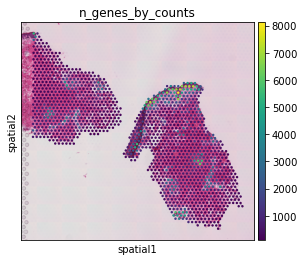

In [5]:
sc.pp.calculate_qc_metrics(adata_st, percent_top=None, log1p=False, inplace=True)

adata_st.obs
sc.pl.spatial(adata_st, color = ["n_genes_by_counts"])


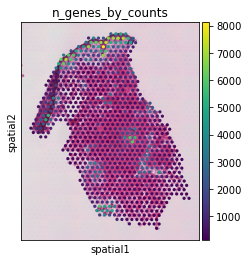

In [8]:
# remove upper left part
val = adata_st.obs["array_col"] + 1.1 * adata_st.obs["array_row"]

adata_st = adata_st[ val > 90,:]
sc.pl.spatial(adata_st, color = ["n_genes_by_counts"])


In [11]:
# make mock cell counts ranging from 0,40
nF = adata_st.obs["n_genes_by_counts"]
nCell = round((nF - min(nF))/max(nF) * 40) 
nCell.value_counts()

1.0     239
2.0     183
3.0      93
4.0      65
5.0      39
0.0      29
6.0      25
8.0      21
7.0      18
12.0     16
11.0     12
9.0      12
10.0     11
13.0     10
14.0      6
15.0      6
24.0      6
21.0      6
19.0      5
28.0      5
16.0      4
30.0      4
35.0      4
22.0      3
18.0      3
33.0      3
23.0      3
26.0      3
17.0      3
29.0      2
20.0      1
39.0      1
32.0      1
34.0      1
25.0      1
Name: n_genes_by_counts, dtype: int64

In [12]:
adata_st.obs["cell_count"]=nCell

In [14]:
adata_st.obs

,in_tissue,array_row,array_col,n_genes_by_counts,total_counts,cell_count
AAACAAGTATCTCCCA-1,1,50,102,789,1452.0,3.0
AAACATTTCCCGGATT-1,1,61,97,429,671.0,1.0
AAACCTAAGCAGCCGG-1,1,65,83,3550,12986.0,17.0
AAACGAGACGGTTGAT-1,1,35,79,640,979.0,2.0
AAACGGGCGTACGGGT-1,1,65,91,241,308.0,0.0
...,...,...,...,...,...,...
TTGTAAGGCCAGTTGG-1,1,27,81,5188,20264.0,25.0
TTGTGAACCTAATCCG-1,1,56,90,577,1009.0,2.0
TTGTGCAGCCACGTCA-1,1,60,74,953,1687.0,4.0
TTGTGGTGGTACTAAG-1,1,63,95,201,232.0,0.0


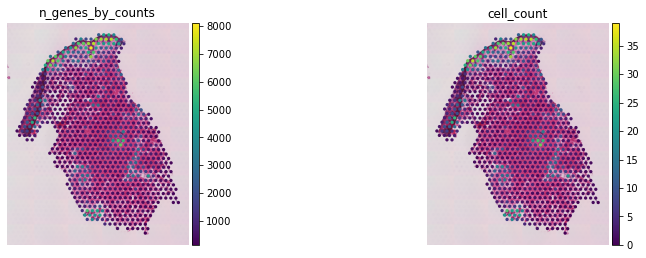

In [15]:
sc.pl.spatial(adata_st, color=["n_genes_by_counts", "cell_count"], frameon=False, library_id = sample)

Predicted number of cells vs counts/genes

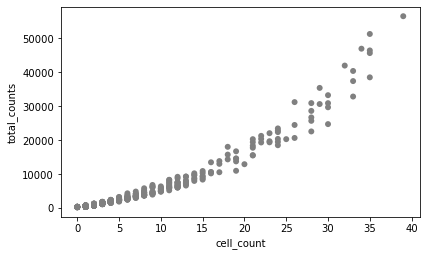

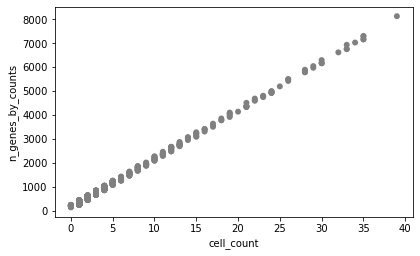

In [17]:
sc.pl.scatter(adata_st, "cell_count", "total_counts")
sc.pl.scatter(adata_st, "cell_count", "n_genes_by_counts")

## Load SC data


In [18]:
sc_dir = '../../scRNAseq/results/'
sc_path = os.path.join(input_dir, "sc_data", "s1_subsampled.h5ad")
adata_sc = sc.read_h5ad(sc_path)
adata_sc

AnnData object with n_obs × n_vars = 9120 × 25778
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'SCT_snn_res.0.8', 'cl.annot'
    var: 'features'

In [19]:
# has normalized counts in .X and counts in raw.X
# OBS! The raw matrix has numericals instead of gene names as var.index
adata_sc.raw.var.index = adata_sc.var.index

In [20]:
# Revert back to raw matrix to have all genes
adata_sc = adata_sc.raw.to_adata()

In [21]:
adata_sc.obs['cl.annot'].value_counts()

VE             385
Mast-cell      381
Granular-II    380
Mono-Mac       378
FB-II          376
Th             376
MEL            374
Spinous-I      374
Granular-I     373
Basal-I        368
PC-vSMC        368
FB-IV          367
Mac            367
FB-III         367
Spinous-II     367
NK-cell        366
Basal-II       366
Spinous-III    364
FB-I           352
DC             312
B-cell         292
Basal-III      290
Basal-IV       286
LE             283
LC             237
Mono-DC        235
Schwann        136
Name: cl.annot, dtype: int64

In [22]:
deg_path = os.path.join(input_dir, "sc_data", "degs_fc0.5_pval0.01.txt")
genes = pd.read_csv(deg_path, header=None) 
genes

,0
0,KRT1
1,KRT10
2,KRTDAP
3,DMKN
4,LGALS7B
...,...
5116,R3HCC1
5117,RNASEH2C
5118,IGF2BP2
5119,GPR17


In [23]:
print(genes.isin(adata_st.var_names).sum())
print(genes.isin(adata_sc.var_names).sum())


genes = list(genes[0])

0    5121
dtype: int64
0    5121
dtype: int64


## Run Tangram 

In [24]:
tg.pp_adatas(adata_sc, adata_st, genes=genes)

INFO:root:5045 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:18253 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [25]:
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="constrained",
    target_count=adata_st.obs.cell_count.sum(),
    density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    num_epochs=1000,
    device="cpu",
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5045 genes and customized density_prior in constrained mode...


Score: 0.242, KL reg: 0.600, Count reg: 454.900, Lambda f reg: 1887.760
Score: 0.595, KL reg: 0.001, Count reg: 1.505, Lambda f reg: 275.143
Score: 0.606, KL reg: 0.000, Count reg: 0.177, Lambda f reg: 69.741
Score: 0.608, KL reg: 0.000, Count reg: 0.046, Lambda f reg: 35.233
Score: 0.609, KL reg: 0.000, Count reg: 0.001, Lambda f reg: 23.026
Score: 0.609, KL reg: 0.000, Count reg: 0.018, Lambda f reg: 17.094
Score: 0.609, KL reg: 0.000, Count reg: 0.023, Lambda f reg: 13.772
Score: 0.609, KL reg: 0.000, Count reg: 0.011, Lambda f reg: 11.753
Score: 0.610, KL reg: 0.000, Count reg: 0.011, Lambda f reg: 10.428
Score: 0.610, KL reg: 0.000, Count reg: 0.000, Lambda f reg: 9.526


INFO:root:Saving results..


In [26]:
tg.project_cell_annotations(ad_map, adata_st, annotation="cl.annot")


INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [27]:
adata_st.obs = pd.concat([adata_st.obs, adata_st.obsm["tangram_ct_pred"]], axis=1)


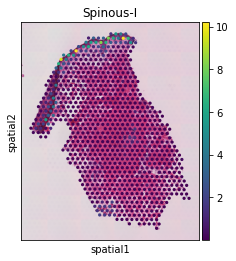

In [28]:
adata_st.obsm["tangram_ct_pred"]["Spinous-I"]

sc.pl.spatial(
    adata_st,
    color=["Spinous-I"],
)

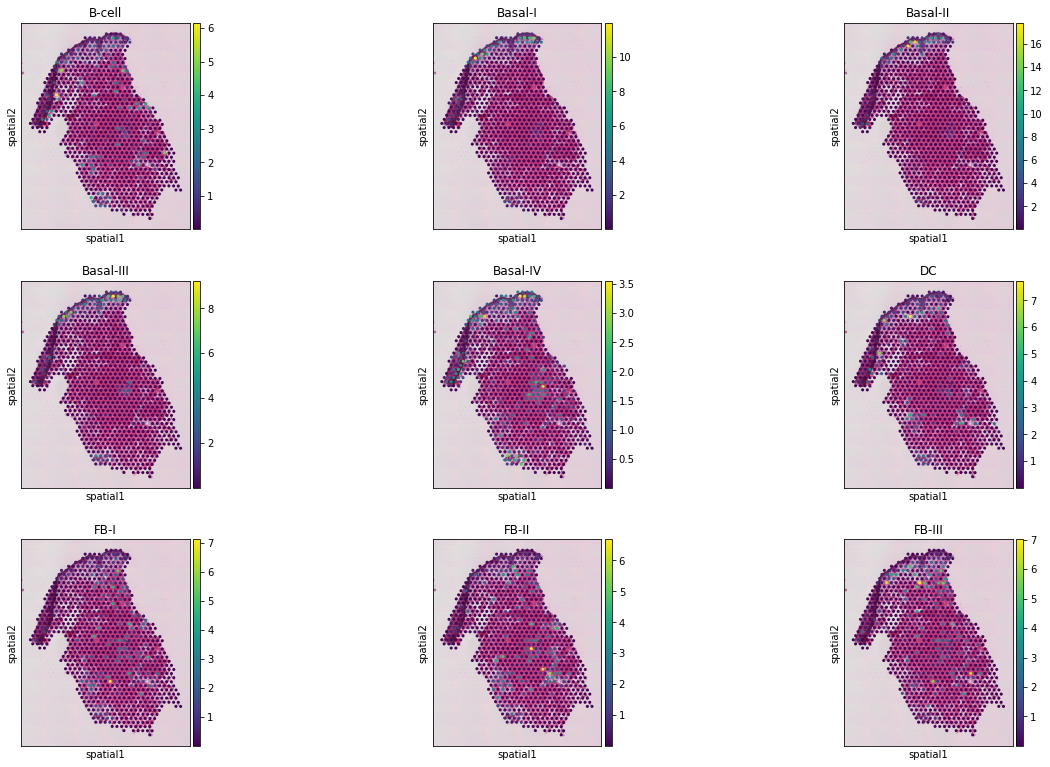

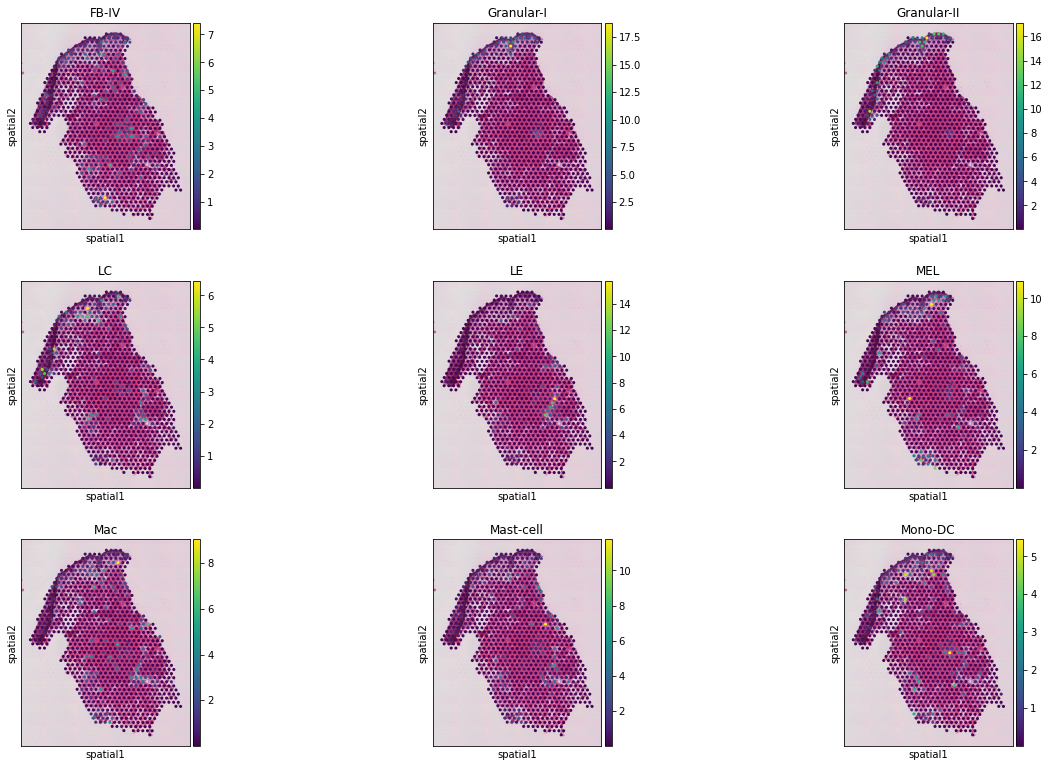

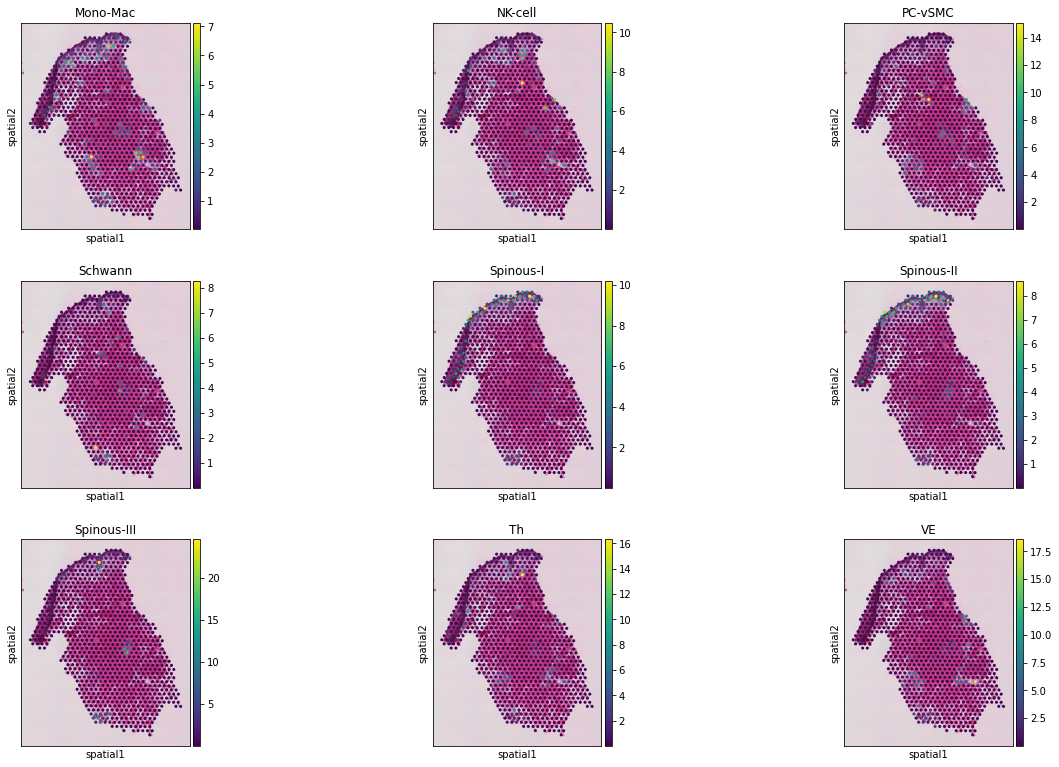

In [29]:
celltypes = adata_sc.obs['cl.annot'].unique()
celltypes = sorted(celltypes)

# plot 9 at a time (have 27 celltypes)
sc.pl.spatial(
    adata_st,
    color=celltypes[:9],
    ncols=3,
)
sc.pl.spatial(
    adata_st,
    color=celltypes[9:18],
    ncols=3,
)
sc.pl.spatial(
    adata_st,
    color=celltypes[18:27],
    ncols=3,
)

In [32]:
adata_st

AnnData object with n_obs × n_vars = 844 × 18493
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'cell_count', 'uniform_density', 'rna_count_based_density', 'Th', 'Basal-I', 'DC', 'FB-II', 'LE', 'MEL', 'Mast-cell', 'Mac', 'Granular-II', 'FB-III', 'Mono-Mac', 'Spinous-II', 'Mono-DC', 'Granular-I', 'PC-vSMC', 'FB-IV', 'FB-I', 'LC', 'Spinous-I', 'B-cell', 'Basal-II', 'VE', 'NK-cell', 'Spinous-III', 'Basal-IV', 'Basal-III', 'Schwann'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'sparsity'
    uns: 'spatial', 'training_genes', 'overlap_genes'
    obsm: 'spatial', 'tangram_ct_pred'

In [70]:
# convert to cell numbers, will not work without the tangram image_features
# adata_st.obsm['image_features'], with 
# segmentation_label, segmentation_centroid

#adata_st.obs["cell_count"]
adata_st.obs

adata_st.obsm["spatial"][0,:].tolist() 
int(adata_st.obs["cell_count"][0])

[adata_st.obsm["spatial"][0,:].astype("float").tolist()] * int(adata_st.obs["cell_count"][0])

[[33145.0, 29879.0], [33145.0, 29879.0], [33145.0, 29879.0]]

In [69]:
adata_st.obsm["spatial"][0,:].astype("float").tolist() 

[33145.0, 29879.0]

In [130]:
centroids = [ [adata_st.obsm["spatial"][i,:].astype("float").tolist()] * int(adata_st.obs["cell_count"][i]) for i in range(adata_st.n_obs)]


imfeats = pd.DataFrame({"segmentation_label" : adata_st.obs["cell_count"].astype("int"), "segmentation_centroid" : centroids })
imfeats

,segmentation_label,segmentation_centroid
AAACAAGTATCTCCCA-1,3,"[[33145.0, 29879.0], [33145.0, 29879.0], [3314..."
AAACATTTCCCGGATT-1,1,"[[31652.0, 35433.0]]"
AAACCTAAGCAGCCGG-1,17,"[[27567.0, 37428.0], [27567.0, 37428.0], [2756..."
AAACGAGACGGTTGAT-1,2,"[[26512.0, 22243.0], [26512.0, 22243.0]]"
AAACGGGCGTACGGGT-1,0,[]
...,...,...
TTGTAAGGCCAGTTGG-1,25,"[[27123.0, 18200.0], [27123.0, 18200.0], [2712..."
TTGTGAACCTAATCCG-1,2,"[[29635.0, 32889.0], [29635.0, 32889.0]]"
TTGTGCAGCCACGTCA-1,4,"[[24968.0, 34880.0], [24968.0, 34880.0], [2496..."
TTGTGGTGGTACTAAG-1,0,[]


In [132]:
imfeats['segmentation_centroid'] =  [[[]] if len(x) == 0 else x for x in imfeats['segmentation_centroid']]


In [133]:
#imfeats[imfeats.segmentation_label == 0]["segmentation_centroid"] = 5
imfeats

,segmentation_label,segmentation_centroid
AAACAAGTATCTCCCA-1,3,"[[33145.0, 29879.0], [33145.0, 29879.0], [3314..."
AAACATTTCCCGGATT-1,1,"[[31652.0, 35433.0]]"
AAACCTAAGCAGCCGG-1,17,"[[27567.0, 37428.0], [27567.0, 37428.0], [2756..."
AAACGAGACGGTTGAT-1,2,"[[26512.0, 22243.0], [26512.0, 22243.0]]"
AAACGGGCGTACGGGT-1,0,[[]]
...,...,...
TTGTAAGGCCAGTTGG-1,25,"[[27123.0, 18200.0], [27123.0, 18200.0], [2712..."
TTGTGAACCTAATCCG-1,2,"[[29635.0, 32889.0], [29635.0, 32889.0]]"
TTGTGCAGCCACGTCA-1,4,"[[24968.0, 34880.0], [24968.0, 34880.0], [2496..."
TTGTGGTGGTACTAAG-1,0,[[]]


In [134]:
adata_st.obsm['image_features'] = imfeats

In [135]:
tg.create_segment_cell_df(adata_st)

INFO:root:cell segmentation dataframe is saved in `uns` `tangram_cell_segmentation` of the spatial AnnData.
INFO:root:spot centroids is saved in `obsm` `tangram_spot_centroids` of the spatial AnnData.


In [136]:
adata_st.uns["tangram_cell_segmentation"].head()

,spot_idx,y,x,centroids
0,AAACAAGTATCTCCCA-1,33145.0,29879.0,AAACAAGTATCTCCCA-1_0
1,AAACAAGTATCTCCCA-1,33145.0,29879.0,AAACAAGTATCTCCCA-1_1
2,AAACAAGTATCTCCCA-1,33145.0,29879.0,AAACAAGTATCTCCCA-1_2
3,AAACATTTCCCGGATT-1,31652.0,35433.0,AAACATTTCCCGGATT-1_0
4,AAACCTAAGCAGCCGG-1,27567.0,37428.0,AAACCTAAGCAGCCGG-1_0


In [137]:
tg.count_cell_annotations(
    ad_map,
    adata_sc,
    adata_st,
    annotation="cl.annot",
)

INFO:root:spatial cell count dataframe is saved in `obsm` `tangram_ct_count` of the spatial AnnData.


In [138]:
adata_st.obsm["tangram_ct_count"].head()

,x,y,cell_n,centroids,Th,Basal-I,DC,FB-II,LE,MEL,...,LC,Spinous-I,B-cell,Basal-II,VE,NK-cell,Spinous-III,Basal-IV,Basal-III,Schwann
AAACAAGTATCTCCCA-1,29879,33145,3,"[AAACAAGTATCTCCCA-1_0, AAACAAGTATCTCCCA-1_1, A...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
AAACATTTCCCGGATT-1,35433,31652,1,[AAACATTTCCCGGATT-1_0],0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
AAACCTAAGCAGCCGG-1,37428,27567,17,"[AAACCTAAGCAGCCGG-1_0, AAACCTAAGCAGCCGG-1_1, A...",1,0,1,0,1,3,...,0,0,1,0,1,1,3,0,2,1
AAACGAGACGGTTGAT-1,22243,26512,2,"[AAACGAGACGGTTGAT-1_0, AAACGAGACGGTTGAT-1_1]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGGGCGTACGGGT-1,37444,29893,0,[],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
# save files
outdir = "../../../deconv/results/tangram/Donor1_Skin/"

adata_st.obsm["tangram_ct_count"].to_csv(os.path.join(outdir,"mock_segment_counts.csv"))
adata_st.obsm["tangram_ct_pred"].to_csv(os.path.join(outdir,"mock_segment_scores.csv"))


## Compare results

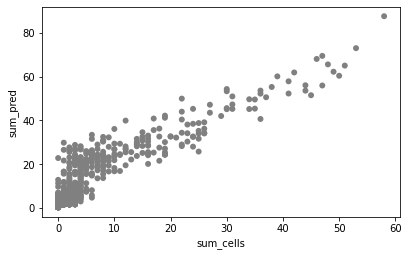

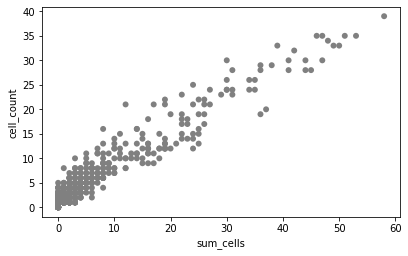

In [163]:
adata_st.obs.columns

ct_count = adata_st.obsm["tangram_ct_count"].iloc[:,4:]

nC = ct_count.sum(axis = 1)
adata_st.obs["sum_cells"] = nC
nP = adata_st.obsm["tangram_ct_pred"].sum(axis = 1)
adata_st.obs["sum_pred"] = nP

sc.pl.scatter(adata_st, "sum_cells", "sum_pred")
sc.pl.scatter(adata_st, "sum_cells", "cell_count")

In [174]:
adata_st.obsm["tangram_ct_pred"]
adata_st.obs["quantile_ncells"] = pd.qcut(adata_st.obs['sum_cells'], q=10, duplicates = 'drop').astype("category")

adata_st.obs["binned_ncells"] = pd.cut(adata_st.obs['sum_cells'], bins=10).astype("category")


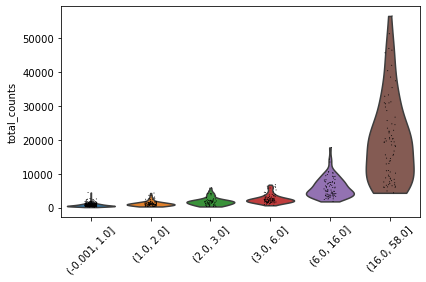

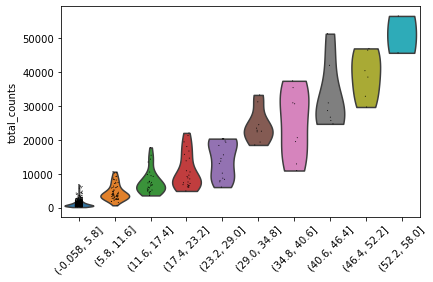

In [177]:
sc.pl.violin(adata_st,"total_counts", "quantile_ncells", rotation=45)
sc.pl.violin(adata_st,"total_counts", "binned_ncells", rotation=45)

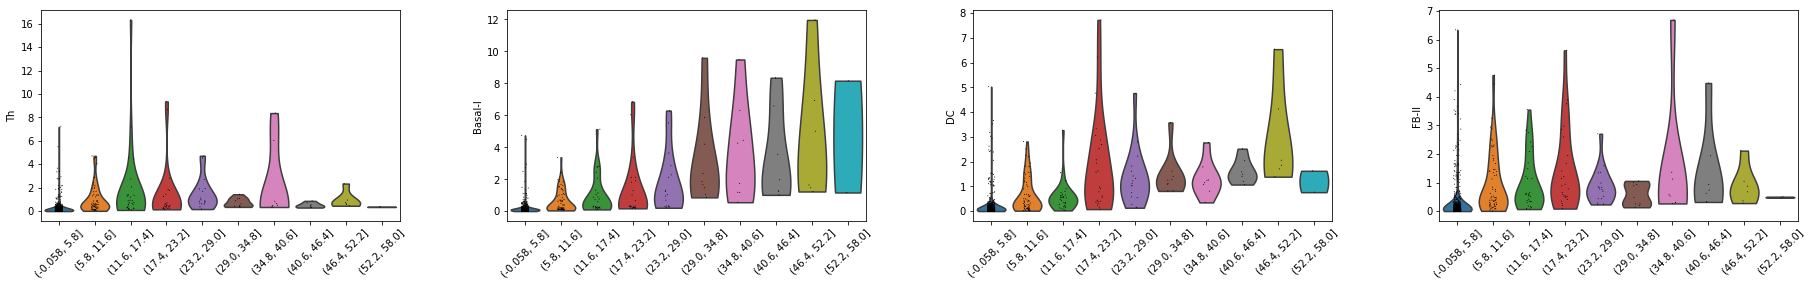

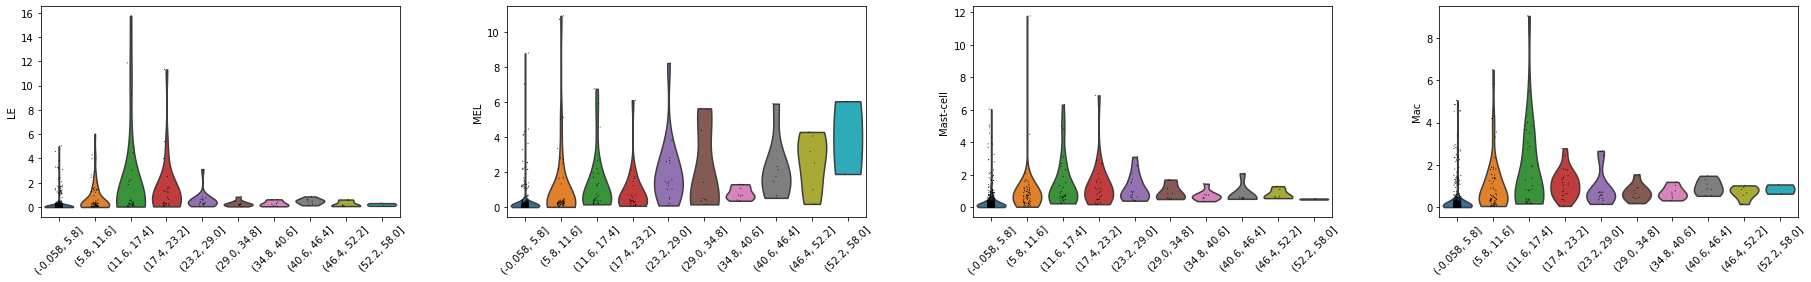

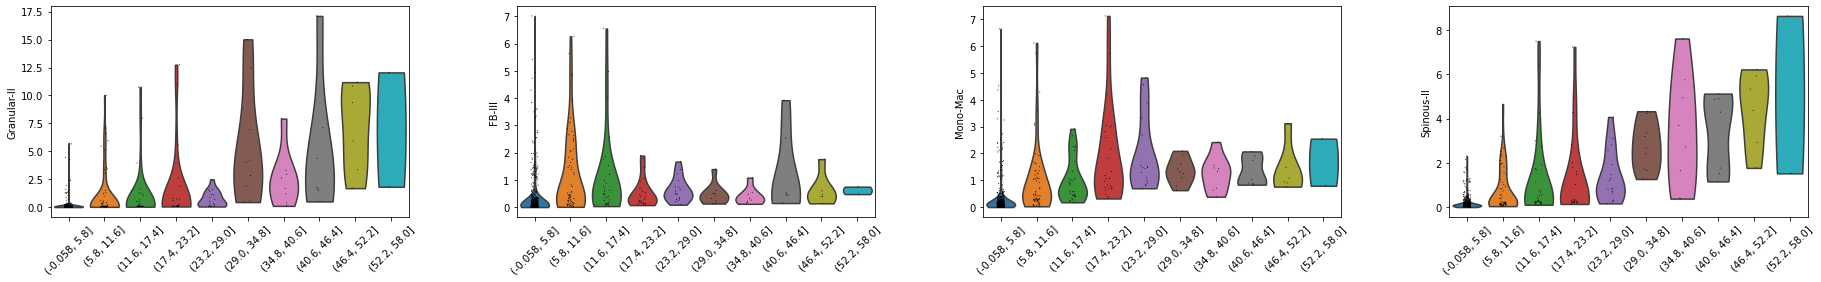

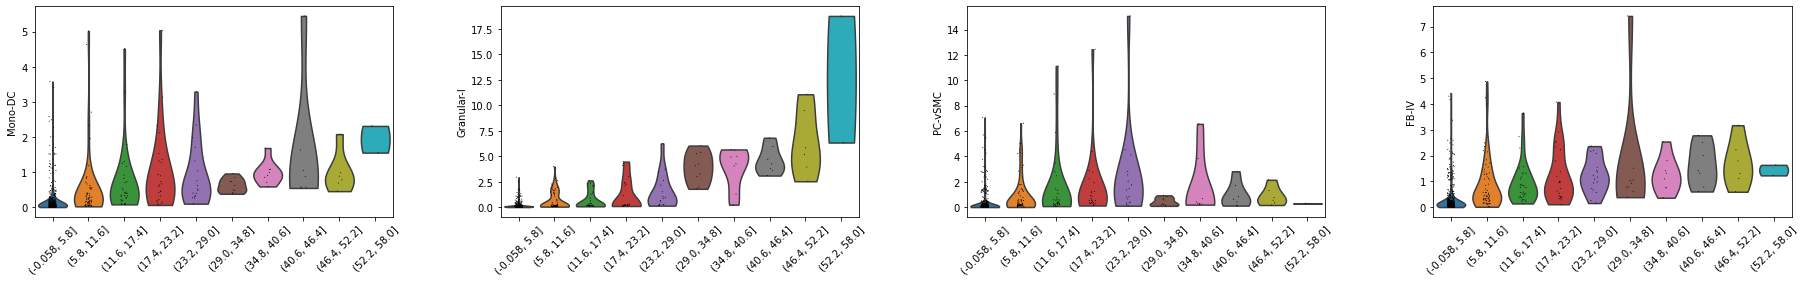

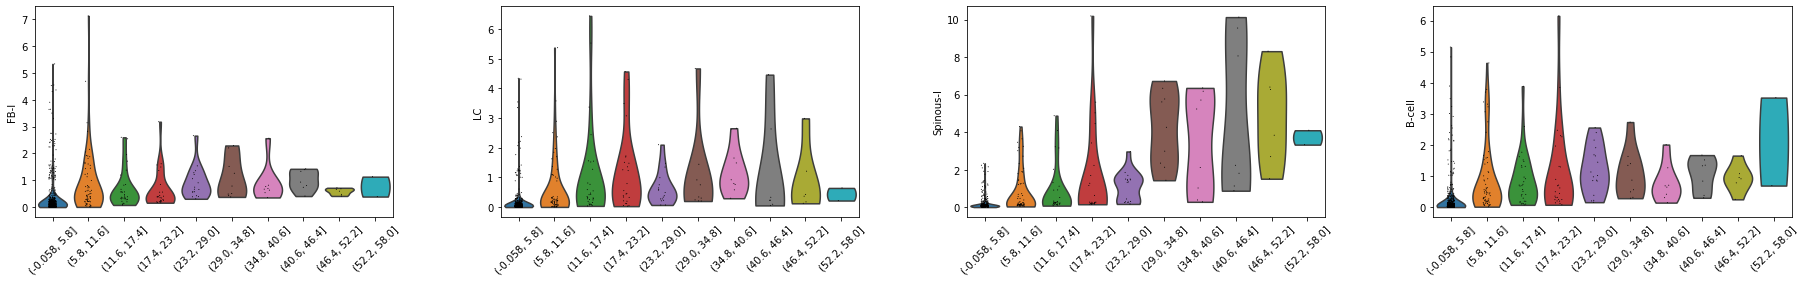

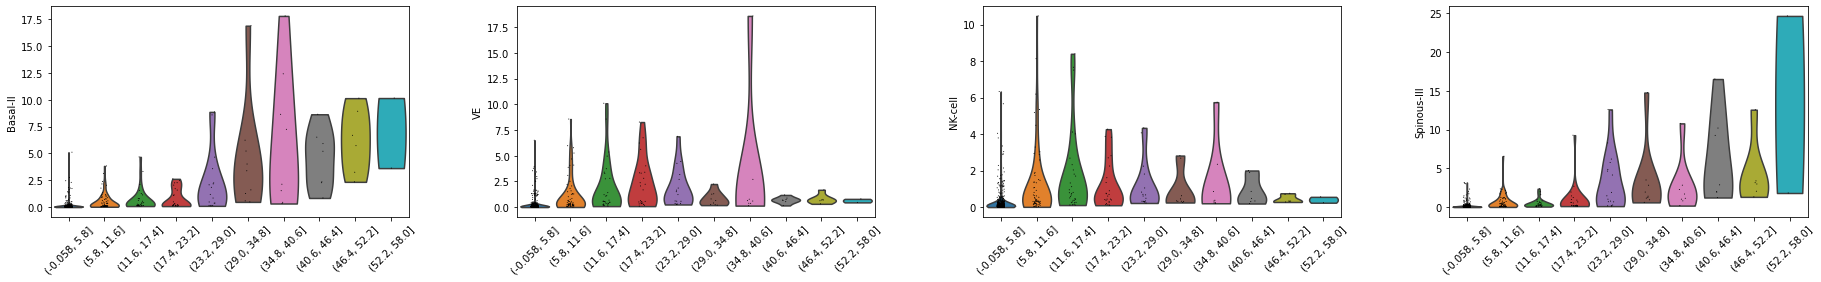

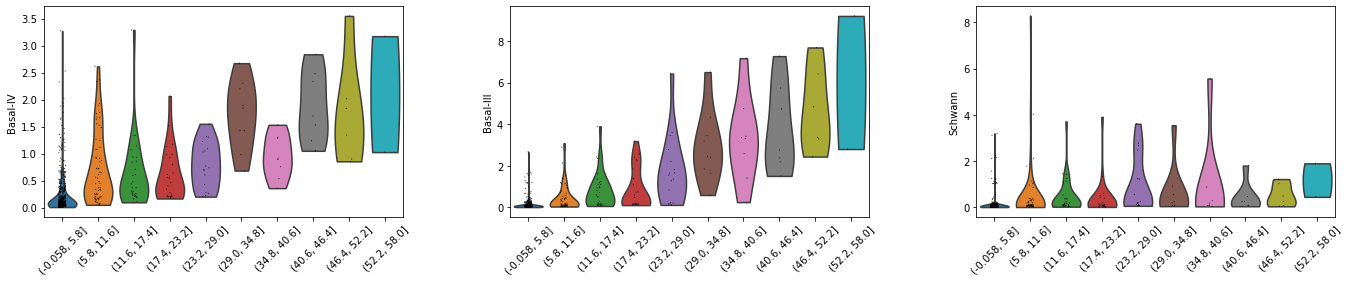

In [184]:
# plot each celltype by number of cells per spot


sc.pl.violin(adata_st,celltypes[:4], "binned_ncells", rotation=45)
sc.pl.violin(adata_st,celltypes[4:8], "binned_ncells", rotation=45)
sc.pl.violin(adata_st,celltypes[8:12], "binned_ncells", rotation=45)
sc.pl.violin(adata_st,celltypes[12:16], "binned_ncells", rotation=45)
sc.pl.violin(adata_st,celltypes[16:20], "binned_ncells", rotation=45)
sc.pl.violin(adata_st,celltypes[20:24], "binned_ncells", rotation=45)
sc.pl.violin(adata_st,celltypes[24:], "binned_ncells", rotation=45)

In [193]:
ct_count.sum(axis=0).sort_values()


Schwann         53
Mono-DC        107
LC             108
Basal-IV       123
LE             130
B-cell         130
Basal-III      145
NK-cell        148
MEL            150
FB-III         154
PC-vSMC        155
DC             159
Spinous-III    159
Th             163
Basal-I        163
Basal-II       164
Granular-I     164
FB-IV          165
FB-II          165
Spinous-II     165
FB-I           167
Mac            167
Granular-II    170
Spinous-I      172
VE             173
Mast-cell      174
Mono-Mac       184
dtype: int64

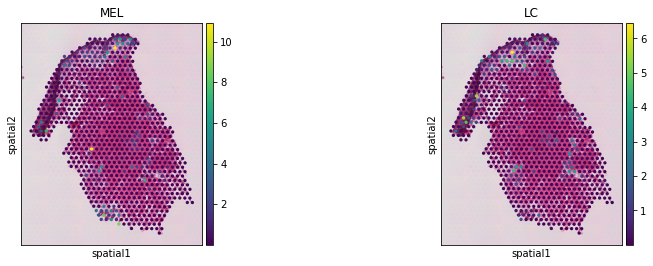

In [194]:

sc.pl.spatial(
    adata_st,
    color=["MEL","LC"],
    ncols=3,
)